Implementation from paper: [Bengio et al. 2003 MLP language model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline
import random
import torch
torch.set_default_device("cpu")

In [2]:
words = open("../data/names.txt", 'r').read().splitlines()
len(words), words[:10]

(32033,
 ['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'])

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
#   print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
C = torch.randn((27, 2), requires_grad=True)
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [7]:
W1 = torch.randn((6, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)

In [8]:
# 3 ways to reshape the tensor
# x_reshaped = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
# x_reshaped = torch.cat(torch.unbind(emb, 1)                      , 1)
x_reshaped  = emb.view(emb.shape[0], 6)
x_reshaped.shape

torch.Size([228146, 6])

In [9]:
h = torch.tanh(x_reshaped @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [10]:
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

In [11]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [12]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape, prob[0].sum()

(torch.Size([228146, 27]), tensor(1.0000, grad_fn=<SumBackward0>))

In [13]:
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

## Organized better:

In [14]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [15]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [16]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [17]:
for p in parameters:
    p.requires_grad = True

In [18]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [19]:
lri = []
lossi = []
stepi = []

for i in range(200_000):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 10**-1 if i < 100_000 else 10**-2
    for p in parameters:
        p.data -= p.grad * lr
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print("Final loss:", loss.item())

Final loss: 1.9052143096923828


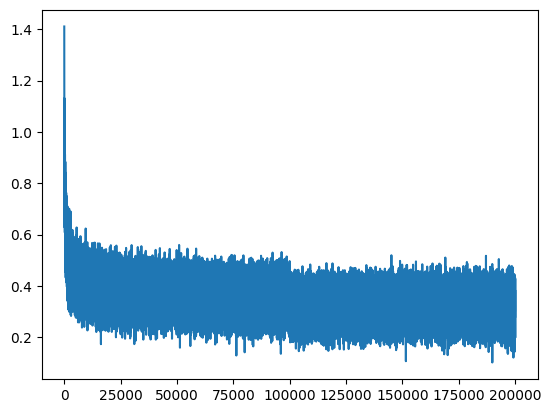

In [20]:
plt.plot(stepi, lossi)

In [21]:
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1652495861053467


In [22]:
emb = C[Xte]
h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.162371873855591


In [24]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(100):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amoriq.
khy.
mylire.
tyr.
kanden.
jazhnevalee.
art.
kaeli.
ner.
kentziaiir.
kaleigh.
ham.
prin.
quint.
shovera.
jadia.
wajero.
dearisia.
kaelynn.
deley.
ediia.
gian.
hasta.
alaas.
bel.
husya.
dembrion.
ajoor.
mikaai.
ren.
kensa.
lulo.
zoe.
silora.
huxner.
moklynn.
and.
den.
loun.
lyn.
braya.
kenzi.
marvion.
der.
rasislyn.
ken.
kaizleynadak.
kyles.
anielambreal.
kyah.
catooro.
bowrina.
moking.
jozellezes.
auleolinni.
eressi.
kyroy.
baryiel.
cha.
ashya.
joshan.
shandryadit.
hayorah.
sur.
disalynn.
kally.
bitha.
ryn.
kel.
catiyah.
della.
joulica.
dhaviah.
siah.
zaxeidra.
samiraiwiminah.
abdue.
elta.
rel.
dyileh.
kalyssa.
amaa.
sammajore.
joiy.
harlyn.
caliiah.
azson.
gevan.
moline.
talenaiie.
randreajexe.
aebya.
kenszon.
duty.
faizia.
mohamdissadery.
everiah.
zeniuesye.
estin.
